# Введение в ML

## Исходные данные

Для начала скопируйте в корень гугл диска (своего) директорию с данными https://drive.google.com/drive/folders/1f0xJzIxfsfI_QbE6VB82W7xkcxTipgkP?usp=sharing

Будем использовать датасет по стоимости страховых услуг - подробнее см. [соревнование на Kaggle](https://www.kaggle.com/mirichoi0218/insurance)

In [1]:
import logging
import os
import shutil 

import numpy as np
#from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = './..' 
# drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'hse_nlp_2021')
if not os.path.exists(root_data_dir):
    raise RuntimeError('Отсутствует директория с данными')
else:
    logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2023-01-30 20:52:59,034 : INFO : Инициализировали логгер
2023-01-30 20:52:59,035 : INFO : Подключили диск
2023-01-30 20:52:59,036 : INFO : Содержимое директории ./../hse_nlp_2021: ['client_segmentation.csv', 'memes', 'nltk_data', 'nltk_data_old', 'politic_meme.jpg', 'recsys_data', 'torch_models', 'gray_goose.jpg', 'clustering.pkl', 'eigen.pkl', 'boosting_toy_dataset.csv', 'nyt-ingredients-snapshot-2015.csv', 'insurance.csv', 'final_dataset.zip', 'my_little_recsys', 'logs', 'optimal_push_time', 'ocr_dataset.zip', 'sklearn_data', 'corpora', 'test_task_data', 'non_linear.csv']


Среди файлов находится `insurance.csv` - это и есть данные по стоимости страховки, на примере которых мы познакомимся с основными понятиями ML

Прочитаем файл с помощью бибилиотеки pandas

In [2]:
import os
import pandas as pd

insurance_df = pd.read_csv(os.path.join(root_data_dir, 'insurance.csv'))

insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Наш таргет (целевая переменная) находится в столбце `charges`

Визуализируем переменную с помощью `.scatter`

/var/folders/qw/svx0bhnn5pj03x1f1yrsknq40000gn/T/ipykernel_33791/609032947.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


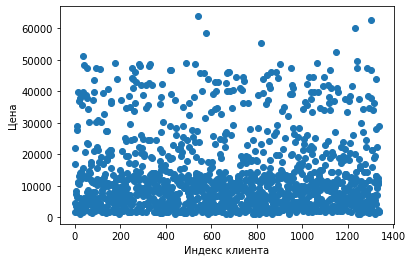

In [3]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

y = insurance_df['charges']

fig, subplot = plt.subplots()
plt.scatter(
    np.arange(len(y)),
    y
)
subplot.set_xlabel('Индекс клиента')
subplot.set_ylabel('Цена')
fig.show()

Получается не очень наглядно - попробуем визуализировать с помощью метода `.hist()` который реализован в pandas

<AxesSubplot:>

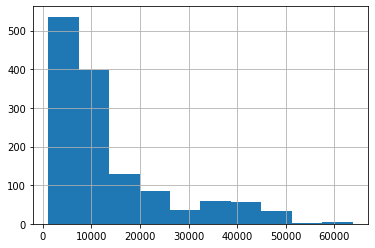

In [4]:
y.hist()

Для каждого объекта построим предсказания с помощью модели линейной регрессии. Воспользуемся как чёрным ящиком питоновским объектом из бибилиотеки [sklearn](https://scikit-learn.org/stable/)

Модели машинного обучения не могут работать с текстом напрямую (вспоминаем лекцию) - а у нас много текстовых полей, их нужно трансформировать в числа - воспользуемся классом `sklearn.preprocessing.LabelEncoder` из библиотеки sklearn

Чтобы преобразовать колонку в текст нужно воспользоватьеся методом [.fit_transform()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder.fit_transform)

In [5]:
from sklearn.preprocessing import LabelEncoder

for label in ['sex', 'smoker', 'region']:
    insurance_df[label] = LabelEncoder().fit_transform(insurance_df[label])

insurance_df.head()
#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Обучим линейную регрессию - это класс [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

Что нужно для счастья
* создать объект
* вызвать метод *.fit()*

Загляните в документацию метода [.fit()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) который принимает на вход два аргумента

* $X$ - матрица объекты - признаки. Удалите из датафрейма `insurance_df` столбец `charges` и сохраните результат в переменную $X$
* `y` - значение целевой переменной

In [6]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()  # объект модели линейной регрессии 

X = insurance_df.drop('charges', axis=1)
y = insurance_df['charges']
reg.fit(X, y)

LinearRegression()

Добавим к датафрейму столбец `prediction`

In [7]:
insurance_df['prediction'] = reg.predict(X)

Задача - посчитайте эмпирический риск по формуле 

$$
Q_{\text{emp}}(h) = \frac{1}{N}\sum_{i=1}^{N}L(h(x_i, \theta), y_i)
$$

где $h(\cdot)$ - значение столбца prediction

Для удобства создайте столбец `squared_loss` - там должно храниться значение $L(y,\hat{y})$:

$L(y,\hat{y}) = (y - \hat{y})^2$

Пользоваться можно только функциями pandas

Полученное значение $Q$ округлите с помощью `np.round(Q, decimals=1)`

In [10]:
num_rows = insurance_df.shape[0]
insurance_df['squared_loss'] = np.zeros(num_rows)
#-------- ВАШ КОД ТУТ -------------------

insurance_df['squared_loss'] = np.round((insurance_df['prediction'] - insurance_df['charges']).pow(2), decimals=1)



#----------------------------------------

Визуализируем гистограмму остатков линейной регрессии - это разница между истинным и предсказанным значением.

<AxesSubplot:>

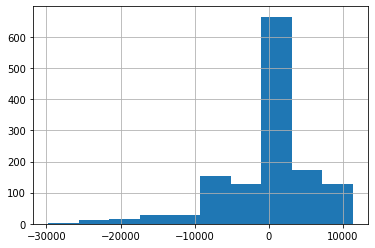

In [11]:
(insurance_df['prediction'] - y).hist()

Кстати, метрику качества необязательно считать вручную - в sklearn реализовано [огромное количество метрик](https://scikit-learn.org/stable/modules/classes.html#regression-metrics) для регрессии (и других задач тоже)

Подробнее о метриках регрессии мы поговорим в дальнейших занятиях

В качестве упражнения посчитайте какую-нибудь метрику - например, MAE - [sklearn.metrics.mean_absolute_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html)

In [13]:
#-------- ВАШ КОД ТУТ -------------------



from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(insurance_df['charges'], insurance_df['prediction'])
mae

#----------------------------------------

4172.48711494405

Мы поговорили про фичи, про метрики - можно немного углубиться в модель, что представляет собой линейная регрессия?

Задача *линейной* регресии: восстановить на функцию $h(x_i)$ в виде *линейной комбинации* (т.е. суммы с некоторыми весами *важности*) признаков объекта. Сами признаки называются *предикторами*:,
$$
\forall x_i: h(x) = w_0 + w_1x_i^1 + \ldots + w_nx_i^n = \sum_{j=1}^{n}w_jx_i^j = \overline{x}_i^T\overline{w}
$$

К признаковому пространству добавляется "фиктивный" признак $x_0=1$, "важность" которого сохраняется в коэффициент $w_0$.

То есть "семейство функций" представляет собой всевозможные комбинации $[w_0, w_1 , w_2 , w_3 , w_4 , w_5 , w_6]$ а метод *.fit()* волшебным образом подбирает их так, чтобы получить максимальное качество.

Мера качества $L$ для задачи регрессии - квадрат разности между фактическим значением и прогнозом. ,
$$
L(h(x_i, \theta), y_i) = \left(y_i - h(x_i, \theta)\right)^2 = \left(y_i -  \sum_{j=1}^{n}w_jx_i^j\right)^2
$$

/var/folders/qw/svx0bhnn5pj03x1f1yrsknq40000gn/T/ipykernel_33791/4042109036.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


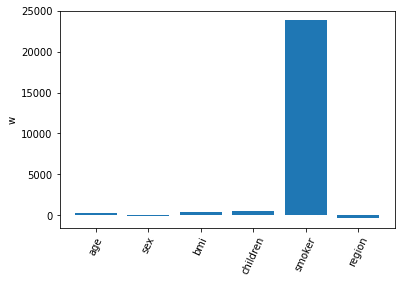

In [14]:
fig, subplot = plt.subplots()
plt.bar(np.arange(len(reg.coef_)), reg.coef_)
subplot.set_xticks(np.arange(len(reg.coef_)))
subplot.set_xticklabels(X.columns.tolist(), rotation=65)
subplot.set_ylabel('w')
fig.show()

В качестве финального задания разберёмся как делать валидацию

Нам понадобится функция [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

Функция принимает несколько аргументов

* `X, y` - первые два аргумента, которые нужно засплиттить
* `test_size=0.33` - доля датасета, которая уйдет в тест
* `random_state=RANDOM_SEED`

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Обучите модель на X_train, y_train вызвав метод fit

In [20]:
validated_reg = LinearRegression()

#-------- ВАШ КОД ТУТ -------------------

validated_reg.fit(X_train, y_train)




#----------------------------------------

LinearRegression()

Сделайте предикт на `X_test`, `y_test` - сохраните его в переменную `y_test_predicted`

In [21]:
y_test_predicted = validated_reg.predict(X_test)

#-------- ВАШ КОД ТУТ -------------------






#----------------------------------------

Посчитайте [sklearn.metrics.mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

* `y_true`
* `y_pred`

Ответ округлите `np.round(mse, decimals=1)`

In [22]:
#-------- ВАШ КОД ТУТ -------------------
from sklearn.metrics import mean_squared_error

mse = np.round(mean_squared_error(y_test, y_test_predicted), decimals=1)
mse





#----------------------------------------

35132017.9